# Purpose
This notebook is  to investigate whether adding the discrete interactions discussed in notebook 3 will be helpful, as imagined.

The discrete interactions will be added on top the MNL and on top the neural net linear spline model.

In [1]:
from collections import OrderedDict
from copy import deepcopy

import numpy as np
import pandas as pd

import pylogit as pl

# Use the following for optimization
from scipy.optimize import minimize

# PyTorch is used for general numeric computation
# with automatic differentiation
import torch
# Used to access various pytorch utilities
import torch.nn as nn
# Used to get sparse matrices
import torch.sparse

# For various posterior predictive checks
from scipy.stats import multivariate_normal
from sklearn.ensemble import (ExtraTreesRegressor,
                              ExtraTreesClassifier)

import seaborn as sbn
import matplotlib.pyplot as plt
%matplotlib inline

import viz

# Create new MNL using interactions from notebook 3

In [2]:
# Load the data
train_df_all =\
    pd.read_csv('./data/mnl_training_data_long_model_checking_data.csv')


In [3]:
# Create needed columns
for df in [train_df_all]:    
    # Add desired discrete interaction variables
    df['income_sector_alt_2_eq_14'] =\
        (df['pred_group_income_sector_alt_2'] == 14).astype(int)


    df['income_num_adults_alt_2_eq_1'] =\
        (df['pred_group_income_num_adults_alt_2'] == 1).astype(int)

    df['income_num_adults_alt_2_eq_2'] =\
        (df['pred_group_income_num_adults_alt_2'] == 2).astype(int)

    df['income_num_adults_alt_2_eq_3'] =\
        (df['pred_group_income_num_adults_alt_2'] == 3).astype(int)

    df['income_num_adults_alt_2_eq_15'] =\
        (df['pred_group_income_num_adults_alt_2'] == 15).astype(int)

    df['income_num_adults_alt_2_eq_16'] =\
        (df['pred_group_income_num_adults_alt_2'] == 16).astype(int)

    df['income_num_adults_alt_3_eq_12'] =\
        (df['pred_group_income_num_adults_alt_3'] == 12).astype(int)


    df['sector_num_adults_alt_2_eq_1'] =\
        (df['pred_group_sector_num_adults_alt_2'] == 1).astype(int)

    df['sector_num_adults_alt_2_eq_8'] =\
        (df['pred_group_sector_num_adults_alt_2'] == 8).astype(int)

    df['sector_num_adults_alt_2_eq_9'] =\
        (df['pred_group_sector_num_adults_alt_2'] == 9).astype(int)

    df['sector_num_adults_alt_3_eq_1'] =\
        (df['pred_group_sector_num_adults_alt_3'] == 1).astype(int)
    
    df['sector_num_adults_alt_3_eq_5'] =\
        (df['pred_group_sector_num_adults_alt_3'] == 5).astype(int)


In [4]:
# Create labels for the various alternatives
choice_labels =\
    {1: '0 Cars',
     2: '1 Car',
     3: '2 Cars',
     4: '3+ Cars',
    }

# Create the specification dictionaries
spec_dict, name_dict = OrderedDict(), OrderedDict()

spec_dict['intercept'] = [2, 3, 4]
spec_dict['num_adults_eq_2'] = [1, 2, 4]
spec_dict['num_adults_gte_3'] = [1, 2, 3]
spec_dict['sectr_1'] = [2, 3, 4]
spec_dict['sectr_2'] = [2, 3, 4]
spec_dict['income_1'] = [2, 3, 4]
spec_dict['income_2'] = [2, 3, 4]
spec_dict['income_4'] = [2, 3, 4]
spec_dict['income_5'] = [2, 3, 4]
spec_dict['income_gt_5'] = [2, 3, 4]

# Add the discrete interaction variables
spec_dict['income_sector_alt_2_eq_14'] = [2]

spec_dict['income_num_adults_alt_2_eq_1'] = [2]
spec_dict['income_num_adults_alt_2_eq_2'] = [2]
spec_dict['income_num_adults_alt_2_eq_3'] = [2]
spec_dict['income_num_adults_alt_2_eq_15'] = [2]
spec_dict['income_num_adults_alt_2_eq_16'] = [2]
spec_dict['income_num_adults_alt_3_eq_12'] = [3]

spec_dict['sector_num_adults_alt_2_eq_1'] = [2]
spec_dict['sector_num_adults_alt_2_eq_8'] = [2]
spec_dict['sector_num_adults_alt_2_eq_9'] = [2]
spec_dict['sector_num_adults_alt_3_eq_1'] = [3]
spec_dict['sector_num_adults_alt_3_eq_5'] = [3]

# Keep the final two sets of variables the same
# as with the original MNL for easy integration
# with the planned hidden layer for transit access
spec_dict['tran_access'] = [2, 3, 4]
spec_dict['numWorkers'] = [2, 3, 4]


for col in spec_dict:
    name_dict[col] =\
        [col + ' ({})'.format(choice_labels[x]) for x in spec_dict[col]]


In [5]:
# Take note of important data columns
ALT_ID_COL = 'altid'
CHOICE_COL = 'choiceBoolean'
OBS_ID_COL = 'sampn'

# Create the model object
mnl_model =\
    pl.create_choice_model(train_df_all,
                           ALT_ID_COL,
                           OBS_ID_COL,
                           CHOICE_COL,
                           spec_dict,
                           'MNL',
                           names=name_dict,
                          )


/Users/tbrathwaite/anaconda2/lib/python2.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


In [6]:
# Fit the model
num_params_mnl = mnl_model.design.shape[1]
init_values = np.zeros(num_params_mnl)

mnl_model.fit_mle(init_values)

# Show model estimation results
mnl_model.get_statsmodels_summary()

Log-likelihood at zero: -14,528.3649
Initial Log-likelihood: -14,528.3649


/Users/tbrathwaite/anaconda2/lib/python2.7/site-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 1.11 seconds.
Final log-likelihood: -8,389.2875


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:               choiceBoolean   No. Observations:               10,480
Model:             Multinomial Logit Model   Df Residuals:                   10,432
Method:                                MLE   Df Model:                           48
Date:                     Mon, 13 Jan 2020   Pseudo R-squ.:                   0.423
Time:                             08:44:06   Pseudo R-bar-squ.:               0.419
AIC:                            16,874.575   Log-Likelihood:             -8,389.287
BIC:                            17,222.922   LL-Null:                   -14,528.365
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
intercept (1 Car)                          2.5783      0.277      9.298      0.000       2.035       3.122
intercept (2 Cars)                         1.0666      0.471      2.264      0.024       0.143       1.990
intercept (3+ Cars)                       -1.9887      1.223     -1.626      0.104      -4.386       0.409
num_adults_eq_2 (0 Cars)                  -3.3908      0.333    -10.171      0.000      -4.044      -2.737
num_adults_eq_2 (1 Car)                   -3.0451      0.340     -8.964      0.000      -3.711      -2.379
num_adults_eq_2 (3+ Cars)                 -1.8491      1.066     -1.735      0.083      -3.938       0.240
num_adults_gte_3 (0 Cars)                 -3.7119      1.023     -3.627      0.000      -5.718      -1.706
num_adults_gte_3 (1 Car)                  -3.5702      1.022     -3.492      0.000      -5.574      -1.566
num_adults_gte_3 (2 Cars)                 -0.5966      1.063     -0.561      0.575      -2.681       1.488
sectr_1 (1 Car)                            0.2908      0.157      1.848      0.065      -0.018       0.599
sectr_1 (2 Cars)                           0.2056      0.219      0.938      0.348      -0.224       0.635
sectr_1 (3+ Cars)                          0.5267      0.323      1.632      0.103      -0.106       1.159
sectr_2 (1 Car)                           -1.5528      0.067    -23.165      0.000      -1.684      -1.421
sectr_2 (2 Cars)                          -3.1787      0.158    -20.092      0.000      -3.489      -2.869
sectr_2 (3+ Cars)                         -3.1848      0.388     -8.215      0.000      -3.945      -2.425
income_1 (1 Car)                          -2.0101      0.152    -13.261      0.000      -2.307      -1.713
income_1 (2 Cars)                         -3.3710      0.361     -9.338      0.000      -4.079      -2.663
income_1 (3+ Cars)                        -3.1432      1.051     -2.990      0.003      -5.204      -1.082
income_2 (1 Car)                          -0.9539      0.085    -11.262      0.000      -1.120      -0.788
income_2 (2 Cars)                         -1.8064      0.164    -11.034      0.000      -2.127      -1.486
income_2 (3+ Cars)                        -2.1029      0.449     -4.679      0.000      -2.984      -1.222
income_4 (1 Car)                           0.8088      0.107      7.588      0.000       0.600       1.018
income_4 (2 Cars)                          1.5170      0.123     12.362      0.000       1.276       1.758
income_4 (3+ Cars)                         1.8261      0.246      7.422      0.000       1.344       2.308
income_5 (1 Car)                           1.3752      0.211      6.522      0.000       0.962       1.788
income_5 (2 Cars)                          3.1891      0.216     14.788      0.000       2.766       3.612
income_5 (3+ Cars)                         3.9077      0.298     13.114      0.000       3.32

# Check the new model

In [7]:
# Set a random seed for reproducibility
np.random.seed(113)

# Create the asymptotic sampling distribution
asymp_sampling_distribution =\
    multivariate_normal(mean=mnl_model.params.values,
                        cov=mnl_model.cov)

# Sample parameters from the sampling distribution
NUM_SAMPLES = 200
# Note we transpose because .rvs returns arrays of shape (size, num_dim)
# But for pylogit, we need arrays of shape (num_dim, size)
param_samples = asymp_sampling_distribution.rvs(size=NUM_SAMPLES).T

# Get the predicted probabilities for each sampled vector of parameters
posterior_probs =\
    mnl_model.predict(train_df_all,
                      param_list=[param_samples, None, None, None])

# Get simulated choices for each vector of predicted probabilities
sim_y =\
    viz.simulate_choice_vector(posterior_probs,
                               train_df_all[OBS_ID_COL].values,
                               rseed=202)


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnU2ltdWxhdGluZyBDaG9pY2VzJywgbWF4PTEwNDgwLjAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGXigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnUGxvdHRpbmcgU2ltdWxhdGlvbnMnLCBtYXg9MjAwLjAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGXigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnUGxvdHRpbmcnLCBtYXg9MS4wLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3dpZHTigKY=


/Users/tbrathwaite/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnUGxvdHRpbmcgU2ltdWxhdGlvbnMnLCBtYXg9MjAwLjAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGXigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnUGxvdHRpbmcnLCBtYXg9MS4wLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3dpZHTigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnUGxvdHRpbmcgU2ltdWxhdGlvbnMnLCBtYXg9MjAwLjAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGXigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnUGxvdHRpbmcnLCBtYXg9MS4wLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3dpZHTigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnUGxvdHRpbmcgU2ltdWxhdGlvbnMnLCBtYXg9MjAwLjAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGXigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnUGxvdHRpbmcnLCBtYXg9MS4wLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3dpZHTigKY=


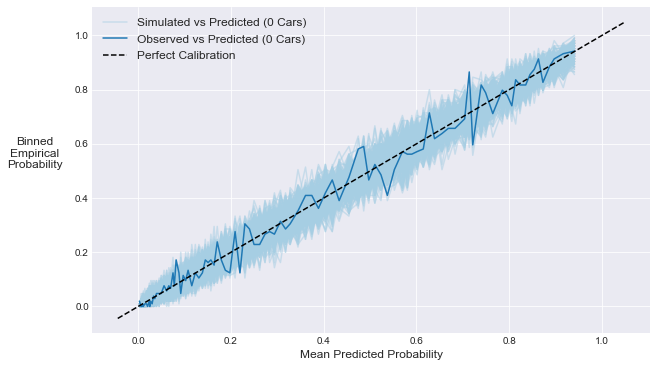

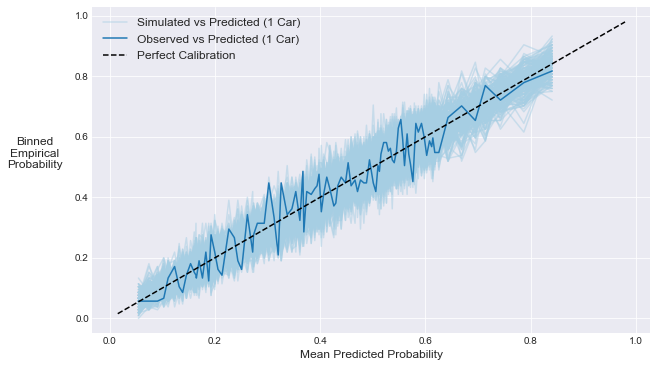

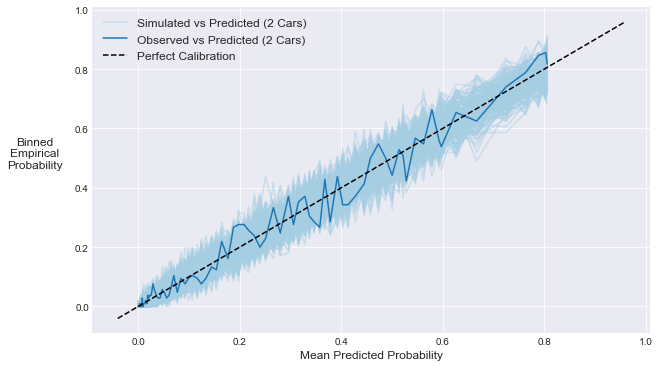

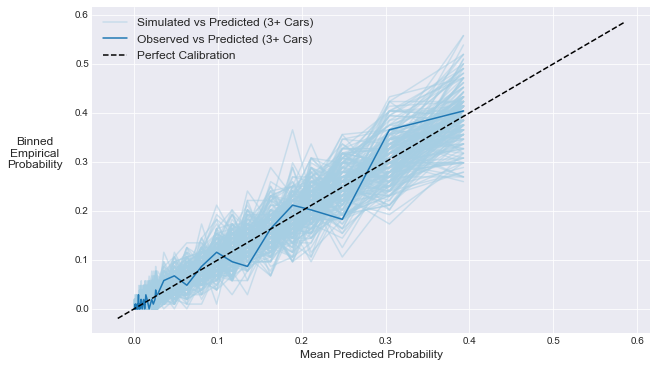

In [8]:
# Get the alternative id's for each row
train_alternative_ids = train_df_all[ALT_ID_COL].values

# Look at the reliability plots for each alternative
for alt in np.sort(np.unique(train_alternative_ids)):
    alt_filter = train_alternative_ids == alt
    alt_name = choice_labels[alt]

    current_sim_y = sim_y[alt_filter, :]
    current_probs = mnl_model.long_fitted_probs[alt_filter]
    current_obs_y = mnl_model.choices[alt_filter]
    
    current_line_label =\
        'Observed vs Predicted ({})'.format(alt_name)
    current_sim_line_label =\
        'Simulated vs Predicted ({})'.format(alt_name)
    
    viz.plot_smoothed_reliability(
        current_probs,
        current_obs_y,
        sim_y=current_sim_y,
        discrete=True,
        partitions=100,
        figsize=(10, 6),
        line_label=current_line_label,
        sim_label=current_sim_line_label,
    )

# Add PyTorch hidden layer for `trans_access`

### Create needed pytorch model classes and helper functions

In [9]:
# 5.0 Make helper functions needed for model training
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def get_numpy_grad(model):
    return np.concatenate(list(x.grad.data.numpy().ravel()
                               for x in model.parameters()),
                          axis=0)

def get_numpy_params(model):
    return np.concatenate(list(x.data.numpy().ravel()
                               for x in model.parameters()),
                          axis=0)


def vec_to_state_dict(vec,
                      model,  
                      param_shapes=None, # keys = param names; vals = size tuple
                     ):
    # Figure out the number of parameters in the model
    total_num_params = count_parameters(model)
    if vec.shape[0] != total_num_params:
        msg = '`vec` and `model` MUST have the same number of parameters.'
        raise ValueError(msg)
    # Create a new state dict
    new_state = deepcopy(model.state_dict())
    # Pointer for slicing the vector for each parameter
    pointer = 0
    for pos, param in enumerate(model.parameters()):
        # The length of the parameter
        num_param = param.numel()
        # Get the name of the current parameter
        param_name = list(new_state.keys())[pos]
        # Slice the vector, reshape it, and replace the old values
        if num_param == 1:
            new_state[param_name] =\
                vec[pointer:pointer + num_param].double()
        else:
            if param_shapes is not None:
                shape_tuple = param_shapes[param_name]
            else:
                shape_tuple = (1, -1)
            new_state[param_name] =\
                vec[pointer:pointer + num_param].view(*shape_tuple).double()
        # Increment the pointer
        pointer += num_param
    return new_state


def set_model_params(params,
                     model,
                     param_shapes=None, # keys = param names vals = size tuple
                    ):
    # Convert the numpy array torch a pytorch tensor
    if isinstance(params, np.ndarray):
        param_tensor =\
            (torch.tensor(params,
                          requires_grad=True)
                  .double())
    else:
        param_tensor = params
    # Conver the vector into a pytorch state dict
    current_state_dict =\
        vec_to_state_dict(param_tensor, model, param_shapes=param_shapes)
    # Load the new state dict onto the model
    model.load_state_dict(current_state_dict)
    return None
        

def make_scipy_closure(
        design,
        targets,
        model,
        loss_func,
        param_shapes=None, # keys = param names vals = size tuple
        ):
    def closure(params):
        # params -> loss, grad
        # Load the parameters onto the model
        set_model_params(params, model, param_shapes=param_shapes)
        # Ensure the gradients are summed starting from zero
        model.zero_grad()
        # Calculate the loss
        loss =\
            loss_func(model(design), targets)
        # Compute the gradients
        loss.backward()
        # Get the gradient.
        grad = get_numpy_grad(model)
        # Get a value of the loss to pass around?
        loss_val = loss.detach().numpy()
        return loss_val, grad
    return closure



In [10]:
# Create the model classes
class MNL_Torch(nn.Module):
    """
    Uses sparse matrices
    """
    def __init__(self,
                 num_index_params,
                 num_alternatives,
                 rows_to_obs, # torch.sparse.FloatTensor
                 min_exponent_val=-700,
                 max_exponent_val=700,
                 max_comp_value=1e300,
                 max_sub_1=1-1e16,
                 min_comp_value=1e-300):
        super(MNL_Torch, self).__init__()
        # Store needed constants for the model
        self.num_alternatives = int(num_alternatives)
        self.num_index_params = int(num_index_params)
        self.rows_to_obs = rows_to_obs
        
        # Store constants related to avoiding numerical overflow or underflow
        self.min_exponent_val = min_exponent_val
        self.max_exponent_val = max_exponent_val
        self.min_comp_value = min_comp_value
        self.max_sub_1 = max_sub_1
        self.max_comp_value = max_comp_value

        # Store computation layers as attributes
        self.linear =\
            nn.Linear(num_index_params, 1, bias=False)
        return None

    def forward(self, inputs):
        # Note we use clamp to guard against later over- or under-flow.
        sys_utilities =\
            torch.clamp(self.calc_sys_utilities(inputs),
                        min=self.min_exponent_val,
                        max=self.max_exponent_val)

        exponentiated_sys_utilities = torch.exp(sys_utilities)

        # Get the denominators for calculating the probabilities
        # There will be one entry per observation
        denominators_by_obs =\
            torch.sparse.mm(self.rows_to_obs.transpose(0, 1),
                            exponentiated_sys_utilities)
        # Convert the denominators into an array of length sys_utilities.size[0]
        long_denominators = torch.sparse.mm(self.rows_to_obs, denominators_by_obs)

        # Note we use clamp to guard against against zero probabilities.
        long_probs =\
            torch.clamp(exponentiated_sys_utilities / long_denominators,
                        min=self.min_comp_value,
                        max=1.0)
        return long_probs
    
    def calc_sys_utilities(self, inputs):
        return self.linear(inputs)

    def convert_long_to_wide(self, input_1d):
        orig_num_rows = input_1d.size()[0]
        new_num_rows =\
            int(orig_num_rows / self.num_alternatives)
        wide_tensor = input_1d.view(new_num_rows, self.num_alternatives)
        return wide_tensor

    def convert_wide_to_long(self, input_2d):
        orig_num_rows = input_2d.size()[0]
        new_num_rows =\
            int(orig_num_rows) * self.num_alternatives
        long_tensor = input_2d.view(new_num_rows, 1)
        return long_tensor

    def safe_logistic(self, inputs):
        safe_input =\
            torch.clamp(inputs,
                        min=self.min_exponent_val,
                        max=self.max_exponent_val)
        return torch.pow(1 + torch.exp(-1 * safe_input), -1)
    
    def safe_logit(self, inputs):
        safe_input =\
            torch.clamp(inputs, min=self.min_comp_value, max=self.max_sub_1)
        return torch.log(safe_input / (1 - safe_input))
    

class HiddenLayerMNL(MNL_Torch):
    def __init__(self,
                 num_index_params,
                 num_alternatives,
                 rows_to_obs, # torch.sparse.FloatTensor
                 num_hidden_units_per_spline=10,
                 min_exponent_val=-700,
                 max_exponent_val=700,
                 max_comp_value=1e300,
                 max_sub_1=1-1e16,
                 min_comp_value=1e-300):
        super(HiddenLayerMNL, self).__init__(
            num_index_params,
            num_alternatives,
            rows_to_obs,
            min_exponent_val=min_exponent_val,
            max_exponent_val=max_exponent_val,
            max_comp_value=max_comp_value,
            max_sub_1=max_sub_1,
            min_comp_value=min_comp_value
        )
        # Store needed constants for the model
        self.num_hidden_units_per_spline = int(num_hidden_units_per_spline)
        
        # Organize info on the splines
        # Note these columns are the trans_access columns
        self.spline_column_list = [-6, -5, -4]
        self.num_splines = len(self.spline_column_list)

        # Create parameters for the splines
        self.spline_linear_coef_params =\
            torch.nn.Parameter(
                torch.zeros(
                    torch.Size([self.num_splines,
                                num_hidden_units_per_spline]
                                ),
                    dtype=torch.double,
                    requires_grad=True))

        self.spline_knot_params =\
            torch.nn.Parameter(
                torch.zeros(
                    torch.Size([self.num_splines,
                                num_hidden_units_per_spline]),
                    dtype=torch.double,
                    requires_grad=True))

        # Combine all spline info
        self.spline_info =\
            [(self.spline_linear_coef_params[x, :],
              self.spline_knot_params[x, :],
              self.spline_column_list[x]) for x in range(self.num_splines)]

        # Create a ReLU layer
        self.relu = nn.ReLU()

        # Store computation layers as attributes
        self.linear =\
            nn.Linear(self.num_index_params, 1, bias=False)
        self.linear.double()
        return None
    
    def calc_sys_utilities(self, inputs):
        # Calculate X * beta
        linear_term = self.linear(inputs)
        
        # Initialize the systematic utility values to be returned
        sys_utility_vals = linear_term
            
        # Calculate the addition to the systematic utilities per spline
        for pos, info in enumerate(self.spline_info):
            # Unpack the info needed from the splines
            spline_linear_coefs, spline_knot_params, col = info
            
            # Compute -1 * exp(spline_linear_coef_param)
            # This ensures the derivative with respect to the transit
            # access variable will be negative for the given alternatives
            # that have 1, 2, or 3+ cars relative to zero cars
            current_transformed_spline_linear_coefs =\
                -1 * torch.exp(torch.clamp(spline_linear_coefs,
                                           min=self.min_exponent_val,
                                           max=self.max_exponent_val))

            # Compute max(0, [x - knot])
            current_pre_spline_vals =\
                self.relu(inputs[:, col][:, None] - spline_knot_params[None, :])

            # Compute 
            # sum_{hidden_units} {-1 * exp(spline_linear_coef_param) *
            #                     max(0, [x - knot])}
            current_spline_vals =\
                torch.mm(current_pre_spline_vals,
                         current_transformed_spline_linear_coefs[:, None])
                
            # Increment the systematic utility values
            sys_utility_vals = sys_utility_vals + current_spline_vals
        return sys_utility_vals
    
    def forward(self, inputs):
        # Note we use clamp to guard against later over- or under-flow.
        sys_utilities =\
            torch.clamp(self.calc_sys_utilities(inputs),
                        min=self.min_exponent_val,
                        max=self.max_exponent_val)

        exponentiated_sys_utilities = torch.exp(sys_utilities)

        # Get the denominators for calculating the probabilities
        # There will be one entry per observation
        denominators_by_obs =\
            torch.sparse.mm(self.rows_to_obs.transpose(0, 1),
                            exponentiated_sys_utilities)
        # Convert the denominators into an array of length sys_utilities.size[0]
        long_denominators =\
            torch.sparse.mm(self.rows_to_obs, denominators_by_obs)

        # Note we use clamp to guard against against zero probabilities.
        long_probs =\
            torch.clamp(exponentiated_sys_utilities / long_denominators,
                        min=self.min_comp_value,
                        max=1.0)
        return long_probs


### Convert training and testing data to pytorch format

In [11]:
# Cast all arrays as 2D arrays of float32 elements
# because that's what pytorch likes
x_train = mnl_model.design.astype(np.float32)
y_train = mnl_model.choices.astype(np.float32)[:, None]

# Convert the data from numpy arrays into pytorch variables
# If .double() is missing then errors will be thrown
x_train_torch = torch.from_numpy(x_train).double()
y_train_torch = torch.from_numpy(y_train).double()


In [12]:
# Get info needed for the pytorch models
num_beta_params = x_train_torch.shape[1]
num_alts = np.unique(train_alternative_ids).size

# Create the pytorch mapping matrices
row_to_obs_mnl_coo =\
    mnl_model.get_mappings_for_fit()['rows_to_obs'].tocoo()

concatenated_row_to_obs_iv_info =\
    torch.from_numpy(
        np.concatenate((row_to_obs_mnl_coo.row[None, :],
                        row_to_obs_mnl_coo.col[None, :]),
                       axis=0)
    ).long()
    
row_to_obs_mnl_data_torch =\
    torch.from_numpy(row_to_obs_mnl_coo.data.astype(np.float32)).double()

rows_to_obs_torch =\
    torch.sparse.FloatTensor(
      concatenated_row_to_obs_iv_info,
      row_to_obs_mnl_data_torch
    ).double()


### Sanity check that the implementations work

In [13]:
# Check that the pytorch MNL implementation works
# Instantiate the MNL
torch_mnl =\
    MNL_Torch(num_beta_params,
              num_alts,
              rows_to_obs_torch).double()

# Set the model parameters from the estimated pylogit params
set_model_params(mnl_model.params.values, torch_mnl)

# Compute probabilities
torch_long_probs = torch_mnl.forward(x_train_torch)
# Get the probabilities as a numpy array
numpy_long_probs_from_torch = torch_long_probs.detach().numpy().ravel()
# Make sure the probabilities are all close-ish
np.allclose(numpy_long_probs_from_torch, mnl_model.long_fitted_probs)

# Chcek that the log-likelihoods are equal-ish
torch_log_like = np.dot(mnl_model.choices,
                        np.log(numpy_long_probs_from_torch.ravel()))
print(torch_log_like, mnl_model.llf)

(-8389.287475718455, -8389.287484610923)


In [14]:
# Look at the percent change between pylogit and pytorch probs
pct_change =\
    ((numpy_long_probs_from_torch - mnl_model.long_fitted_probs) /
     mnl_model.long_fitted_probs)

pd.Series(pct_change).describe(percentiles=
    [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    4.192000e+04
mean     1.986295e-09
std      5.938622e-08
min     -1.986186e-07
1%      -1.501112e-07
5%      -1.038815e-07
10%     -7.120270e-08
25%     -3.192337e-08
50%      5.515367e-10
75%      3.625547e-08
90%      8.195647e-08
95%      1.076067e-07
99%      1.453667e-07
max      2.002462e-07
dtype: float64

The differences are all small (< 2e-7) so I'll ignore them.<br> The differences could come from using 32bit instead of 64bit, etc.

#### Add hidden layers to the MNL model
- Note the "neurons" of this hidden layer are each implementing a piecewise linear term in a spline model.
- There will be one hidden layer for each alternative owning one or more cars.
- This will implement a different piecewise linear spline per utility function.

#### Check that the new model is initialized at the MNL log likelihood

In [15]:
fake_init_params = [ 2.62642643,  1.01238511, -1.96063435, -3.40842236, -3.07128656,
       -1.88427603, -3.82117763, -3.61607187, -0.51202293,  0.56613421,
        0.28484241,  0.68362842, -1.50947467, -2.97806894, -3.27210251,
       -1.89593191, -3.572033  , -3.51079636, -0.99513674, -1.71821255,
       -2.2863024 ,  0.79170679,  1.51121979,  1.82646775,  1.32613353,
        3.16111277,  3.89592762, -0.26263708,  0.27132369,  0.77130529,
       -0.35685592, -0.8649927 , -0.86943909,  0.35927736,  0.76133176,
        1.13920916]


In [16]:
# Determine how many units per spline
NUM_KNOTS = 10
# Initialize the new model
new_model = HiddenLayerMNL(num_beta_params,
                           num_alts,
                           rows_to_obs_torch,
                           num_hidden_units_per_spline=NUM_KNOTS)

####
# Set the initial parameters
####
# Note the shapes of the parameters
param_shape_dict_new_model =\
    {'spline_linear_coef_params': (3, NUM_KNOTS),
     'spline_knot_params': (3, NUM_KNOTS),
     'linear.weight': (1, mnl_model.params.size)}

# Create initial knot values
initial_knot_vals =\
    (pd.Series(train_df_all['tran_access'].values
                   [np.nonzero(train_df_all['tran_access'].values)])
       .describe(percentiles=[0.05 + 0.1 * x
                              for x in range(NUM_KNOTS)])).values[-11:-1]

# Note the initial parameter values as a correctly ordered state dict
initial_vals_new_model = OrderedDict()
initial_vals_new_model['spline_linear_coef_params'] =\
     (torch.from_numpy(
          np.ones((3, NUM_KNOTS)) * -5
#           np.log(np.abs(mnl_model.params.values[[-6, -5, -4]][:, None]))
                      )
           .double())

initial_vals_new_model['spline_knot_params'] =\
     (torch.from_numpy(
         np.ones((3, NUM_KNOTS)) * initial_knot_vals[None, :])
           .double()
     )

initial_vals_new_model['linear.weight'] =\
    torch.from_numpy(mnl_model.params.values[None, :]).double()

# Note the initial parameter values as a correctly ordered numpy
# array we can use to set the parameters with
initial_vals_new_model_numpy =\
    np.concatenate(
        tuple(t.data.numpy().ravel() for t in initial_vals_new_model.values()),
        axis=0)

# Set the model parameters
set_model_params(initial_vals_new_model_numpy,
                 new_model,
                 param_shapes=param_shape_dict_new_model)
new_model.double()

# Look at the current params
print("Model's state_dict:")
for param_tensor in new_model.state_dict():
    print(param_tensor, "\t", new_model.state_dict()[param_tensor].size())
    print(param_tensor, "\t", new_model.state_dict()[param_tensor])
    print('\n')

Model's state_dict:
('spline_linear_coef_params', '\t', torch.Size([3, 10]))
('spline_linear_coef_params', '\t', tensor([[-5., -5., -5., -5., -5., -5., -5., -5., -5., -5.],
        [-5., -5., -5., -5., -5., -5., -5., -5., -5., -5.],
        [-5., -5., -5., -5., -5., -5., -5., -5., -5., -5.]],
       dtype=torch.float64))


('spline_knot_params', '\t', torch.Size([3, 10]))
('spline_knot_params', '\t', tensor([[5.0360, 5.3479, 5.5561, 6.0149, 6.0958, 6.2924, 6.5286, 6.6412, 6.8725,
         7.1814],
        [5.0360, 5.3479, 5.5561, 6.0149, 6.0958, 6.2924, 6.5286, 6.6412, 6.8725,
         7.1814],
        [5.0360, 5.3479, 5.5561, 6.0149, 6.0958, 6.2924, 6.5286, 6.6412, 6.8725,
         7.1814]], dtype=torch.float64))


('linear.weight', '\t', torch.Size([1, 48]))
('linear.weight', '\t', tensor([[ 2.5783,  1.0666, -1.9887, -3.3908, -3.0451, -1.8491, -3.7119, -3.5702,
         -0.5966,  0.2908,  0.2056,  0.5267, -1.5528, -3.1787, -3.1848, -2.0101,
         -3.3710, -3.1432, -0.9539, -1.8064

In [17]:
####
# Check initial probabilities with new model
####

# Compute probabilities
x_train_torch = x_train_torch.double()
torch_long_probs_new = new_model.forward(x_train_torch)
# Get the probabilities as a numpy array
numpy_long_probs_from_torch_new = torch_long_probs_new.data.numpy().ravel()
# Make sure the probabilities are all close-ish
print("Probs all close?",
      np.allclose(numpy_long_probs_from_torch_new, mnl_model.long_fitted_probs))

# Chcek that the log-likelihoods are equal-ish
torch_log_like_new = np.dot(mnl_model.choices,
                        np.log(numpy_long_probs_from_torch_new.ravel()))
print("Log-Likelihood values")
print(torch_log_like_new, mnl_model.llf)

('Probs all close?', False)
Log-Likelihood values
(-8389.138887469135, -8389.287484610923)


Good, the slight differences seen above mean that the splines are affecting the probabilities, as desired.

## Estimate the new model

### Create a loss for the model

In [18]:
class NegLogLikelihood(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        
    def forward(self, probs, targets):
        total_loss =\
            (-1 * torch.dot(torch.flatten(targets),
                            torch.log(torch.flatten(probs))))
        return total_loss


In [19]:
# Set up a loss for pytorch training
pytorch_loss = NegLogLikelihood()

# Determine how many units per spline
NUM_KNOTS = 10

# Re-initialize the new model
new_model = HiddenLayerMNL(num_beta_params,
                           num_alts,
                           rows_to_obs_torch,
                           num_hidden_units_per_spline=NUM_KNOTS)

####
# Set the initial parameters
####
# Note the shapes of the parameters
param_shape_dict_new_model =\
    {'spline_linear_coef_params': (3, NUM_KNOTS),
     'spline_knot_params': (3, NUM_KNOTS),
     'linear.weight': (1, mnl_model.params.size)}

# Create initial knot values that are the percentiels of the transit access variable
initial_knot_vals =\
    (pd.Series(train_df_all['tran_access'].values
                   [np.nonzero(train_df_all['tran_access'].values)])
       .describe(percentiles=[0.05 + 0.1 * x
                              for x in range(NUM_KNOTS)])).values[-11:-1]

# Note the initial parameter values as a correctly ordered state dict
initial_vals_new_model = OrderedDict()

# Start the spline coefficients near zero to be close to the MNL
initial_vals_new_model['spline_linear_coef_params'] =\
     (torch.from_numpy(
         np.ones((3, NUM_KNOTS)) * -5
                      )
           .double())

initial_vals_new_model['spline_knot_params'] =\
     (torch.from_numpy(
         np.ones((3, NUM_KNOTS)) * initial_knot_vals[None, :])
           .double()
     )

initial_vals_new_model['linear.weight'] =\
    torch.from_numpy(mnl_model.params.values[None, :]).double()

# Note the initial parameter values as a correctly ordered numpy
# array we can use to set the parameters with
initial_vals_new_model_numpy =\
    np.concatenate(
        tuple(t.data.numpy().ravel() for t in initial_vals_new_model.values()),
        axis=0)

# Set the initial model parameters
set_model_params(initial_vals_new_model_numpy,
                 new_model,
                 param_shapes=param_shape_dict_new_model)
new_model.double()

# Make sure the input and model has the correct type
x_train_torch = x_train_torch.double()
y_train_torch = y_train_torch.double()

####
# Create numpy compatible loss and gradient
####
# Create the closure for the model
scipy_loss_and_grad =\
    make_scipy_closure(
        x_train_torch,
        y_train_torch,
        new_model,
        pytorch_loss,
        param_shapes=param_shape_dict_new_model)

# Look at the initial loss value
initial_loss_val = pytorch_loss(new_model(x_train_torch), y_train_torch)
print("Initial loss value: {:,.5f}".format(initial_loss_val.data))

Initial loss value: 8,389.13889


### Perform the minimization

In [20]:
# Perform the minimization
results =\
    minimize(
        scipy_loss_and_grad,
        initial_vals_new_model_numpy,
        method='bfgs',
        jac=True)
print(results['message'])

# Look at the current loss value
current_loss_val = pytorch_loss(new_model(x_train_torch), y_train_torch)
print("Final loss value: {:,.5f}".format(current_loss_val.data))

# Look at the current gradient and its norm to assess convergence.
grad = get_numpy_grad(new_model)
grad_norm = np.linalg.norm(grad)
print("Gradient: \n{}".format(grad))
print("Gradient norm: {:,.6f}".format(grad_norm))

Desired error not necessarily achieved due to precision loss.
Final loss value: 8,372.51244
Gradient: 
[ 1.55864988e-04  4.91966359e-06  7.30458375e-05  1.68731289e-04
  1.20072155e-03  2.78337226e-05  1.77816845e-06  7.68616868e-04
  3.49128687e-06  1.37943647e-04  2.63773678e-02  6.51444914e-02
  6.02252907e-03  4.57781511e-03  2.98364742e-03  2.17611147e-03
  5.50229879e-06  5.18146252e-04  9.89860703e-19  0.00000000e+00
 -4.04527870e-12 -1.91464685e-03  4.93555671e-07 -2.36317693e-05
 -9.60574714e-04  1.00062614e-05 -2.41871692e-03  3.37840692e-11
  8.66442617e-06 -8.88325246e-03  4.13520324e-02  3.87204717e-05
  1.61288198e-02  3.28790838e-01  5.72815728e-01 -3.96578700e-04
  1.54963560e-05 -6.02197643e-02  2.00731454e-03 -9.48054529e-01
 -2.77772597e-16 -6.98236834e+00 -3.60567267e-01  8.38700379e-01
  5.34149060e-01 -2.31812685e-01 -2.68787316e-04  9.53820879e-02
  7.22171632e-18  0.00000000e+00  3.99200138e-12  6.30878420e-01
 -1.18219289e-03  4.34229511e-02  7.90177844e-01  1.

### Look at the estimated parameters

In [21]:
# Look at the current params
print("Model's state_dict:")
for param_tensor in new_model.state_dict():
    print(param_tensor, "\t", new_model.state_dict()[param_tensor].size())
    print(param_tensor, "\t", new_model.state_dict()[param_tensor])
    print('\n')

Model's state_dict:
('spline_linear_coef_params', '\t', torch.Size([3, 10]))
('spline_linear_coef_params', '\t', tensor([[-4.2166e+00, -1.2723e+01, -5.1581e+00, -3.9443e-01, -1.2983e+00,
         -9.4238e+00, -1.2455e+01, -2.6306e+00, -5.4931e+00,  1.3616e+00],
        [-2.4499e+00, -1.9320e-01, -1.6070e+00, -9.8955e-01, -1.4407e+00,
         -3.4055e+00, -1.0140e+01, -3.1635e+00, -4.1444e+01, -4.9051e+00],
        [-2.3835e+01, -1.1809e+00, -6.7950e+00, -3.2674e+00, -3.6615e-01,
         -6.3692e+00, -8.6620e-01, -2.1215e+01, -6.1915e+00,  2.4739e-02]],
       dtype=torch.float64))


('spline_knot_params', '\t', torch.Size([3, 10]))
('spline_knot_params', '\t', tensor([[ 6.2679,  6.3888,  6.2686,  5.4927,  6.2506,  5.7182,  5.6130,  5.5153,
          5.4939,  7.3154],
        [-1.7205,  5.2638,  6.0690,  6.5097,  6.5098,  6.0149,  6.0042,  6.5097,
          6.6337,  8.2706],
        [ 7.0096,  5.7225,  6.4013,  6.4037,  6.4030,  6.4094,  5.7227,  5.6564,
          5.3011,  5.2945]], d

In [22]:
# Look at the final knot positions for each alternative
final_spline_knot_params = new_model.spline_knot_params.data.numpy()

for i in [0, 1, 2]:
    print(np.sort(final_spline_knot_params[i, :]))

[5.49271274 5.49393884 5.51534827 5.61297609 5.71822966 6.25062132
 6.26787852 6.2686382  6.38879929 7.31544062]
[-1.72049703  5.26376412  6.00417845  6.01487423  6.06904097  6.50966736
  6.50969327  6.50982084  6.63368879  8.27056624]
[5.29450004 5.30114617 5.65636974 5.72247161 5.7227077  6.40126401
 6.40301801 6.40368943 6.4093579  7.0095674 ]


Hmm, from above I see that I should probably implement a transformation such that the knot positions stay inside the range of the observed data. Otherwise the knot position could go outside the observed data and then start getting gradients of zero...

### Look at the gradient of the estimated parameters

In [23]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    return None
    

def plot_grad_flow_v2(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    return None

Loss value: 8,372.51244


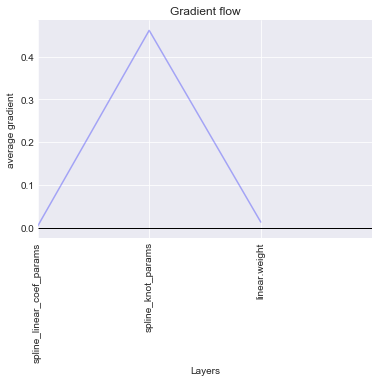

In [24]:
####
# Examine the gradients of the new model
####
# Ensure we start calculating gradients at zero
new_model.zero_grad()
# Look at the initial loss value
current_loss_val = pytorch_loss(new_model(x_train_torch), y_train_torch)
# Get gradients of the loss
current_loss_val.backward()
print("Loss value: {:,.5f}".format(current_loss_val.data))
plot_grad_flow(new_model.named_parameters())

In [25]:
# Save the predictions from the new model
new_model_predictions = pd.Series(new_model(x_train_torch).data.numpy()[:, 0])
new_model_predictions.name = 'TimPredictions'

new_model_predictions.to_csv(
    './data/tb_hybrid_model_predictions.csv',
    index=False,
    header=True)

# Recap

Okay. I'm able to estimate something. The final gradient, while not zero, isn't a horrendously huge number. The main gradient issues seems stem from the non-sensical position that some of the knot parameters ended up in. I can fix this by parameterizing the knot positions to remain within the range of the data.

The training loss has decreased (slightly), which is encouraging. Moreover, the parameters have made significant moves from their starting values. All this makes me think the optimization was decent (though of couse not perfect as we're not even at a local optima with gradient = 0).

Moreover, by adding a few hand-chosen interaction terms that represent 2-way interactions between the discrete variables, I was able to get a log-likelihood almost equivalent to using the full random forest in 1-step of gradient boosting. This seems pretty decent.
